In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa

import sys
sys.path.append('..')
import libfmp.b
import libfmp.c3
import libfmp.c4

In [2]:
def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        fn_wav (str): Filenname of WAV
        Fs (scalar): Sampling rate (Default value = 22050)
        N (int): Window size (Default value = 4096)
        H (int): Hop size (Default value = 2048)
        gamma (float): Constant for logarithmic compression (Default value = None)
        version (str): Technique used for front-end decomposition ('STFT', 'IIS', 'CQT') (Default value = 'STFT')
        norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
            (Default value = '2')

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
    if norm is not None:
        X = libfmp.c3.normalize_feature_sequence(X, norm=norm)
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur


In [3]:
def plot_chromagram_annotation(ax, X, Fs_X, ann, color_ann, x_dur, cmap='gray_r', title=''):
    """Plot chromagram and annotation

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ax: Axes handle
        X: Feature representation
        Fs_X: Feature rate
        ann: Annotations
        color_ann: Color for annotations
        x_dur: Duration of feature representation
        cmap: Color map for imshow (Default value = 'gray_r')
        title: Title for figure (Default value = '')
    """
    libfmp.b.plot_chromagram(X, Fs=Fs_X, ax=ax,
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True)
    libfmp.b.plot_segments_overlay(ann, ax=ax[0], time_max=x_dur,
                                   print_labels=False, colors=color_ann, alpha=0.1)

In [4]:
# Compute chroma features
# fn_wav = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav')
fn_wav = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/data/Audio/if_0172.wav')
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
X_IIR, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X_CQT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

In [5]:
import matplotlib.cm as cm

# Annotations
fn_ann = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/if_0172_chords_converted.csv')
ann, _ = libfmp.c4.read_structure_annotation(fn_ann)
# color_ann = {'N': [1, 1, 1, 1], 'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
#              'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1]}

# 2) Extract all unique chord labels
unique_chords = sorted(set([label for (start, end, label) in ann]))

# 3) Choose a colormap and generate a color for each label
#    e.g., 'tab20' can provide up to 20 distinct colors. 
#    If you have more than 20 chords, pick a different colormap
#    or set a larger "N" parameter (some colormaps support this).
cmap = cm.get_cmap('tab20', len(unique_chords))

# 4) Build a dictionary {chord_label: (RGBA color)}
color_ann = {}
for idx, chord_label in enumerate(unique_chords):
    # 'cmap(idx)' returns an RGBA tuple in the range [0,1]
    color_ann[chord_label] = cmap(idx)

/tmp/ipykernel_92749/3990594699.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_chords))


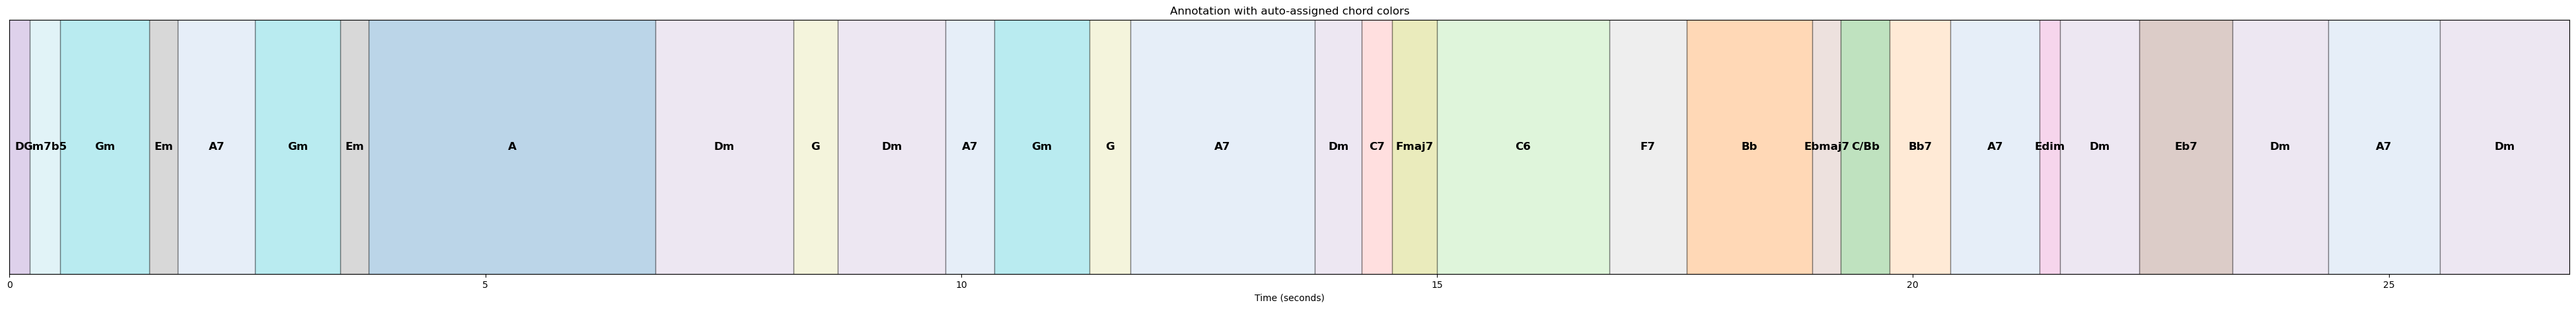

In [31]:
# 5) Use this color dictionary with plot_segments_overlay or plot_segments
import libfmp.b  # for plotting

fig, ax = plt.subplots(figsize=(50, 5))
libfmp.b.plot_segments(ann, ax=ax, time_max=None, time_label='Time (seconds)',
                       colors=color_ann, alpha=0.3)
ax.set_title('Annotation with auto-assigned chord colors')


plt.show()

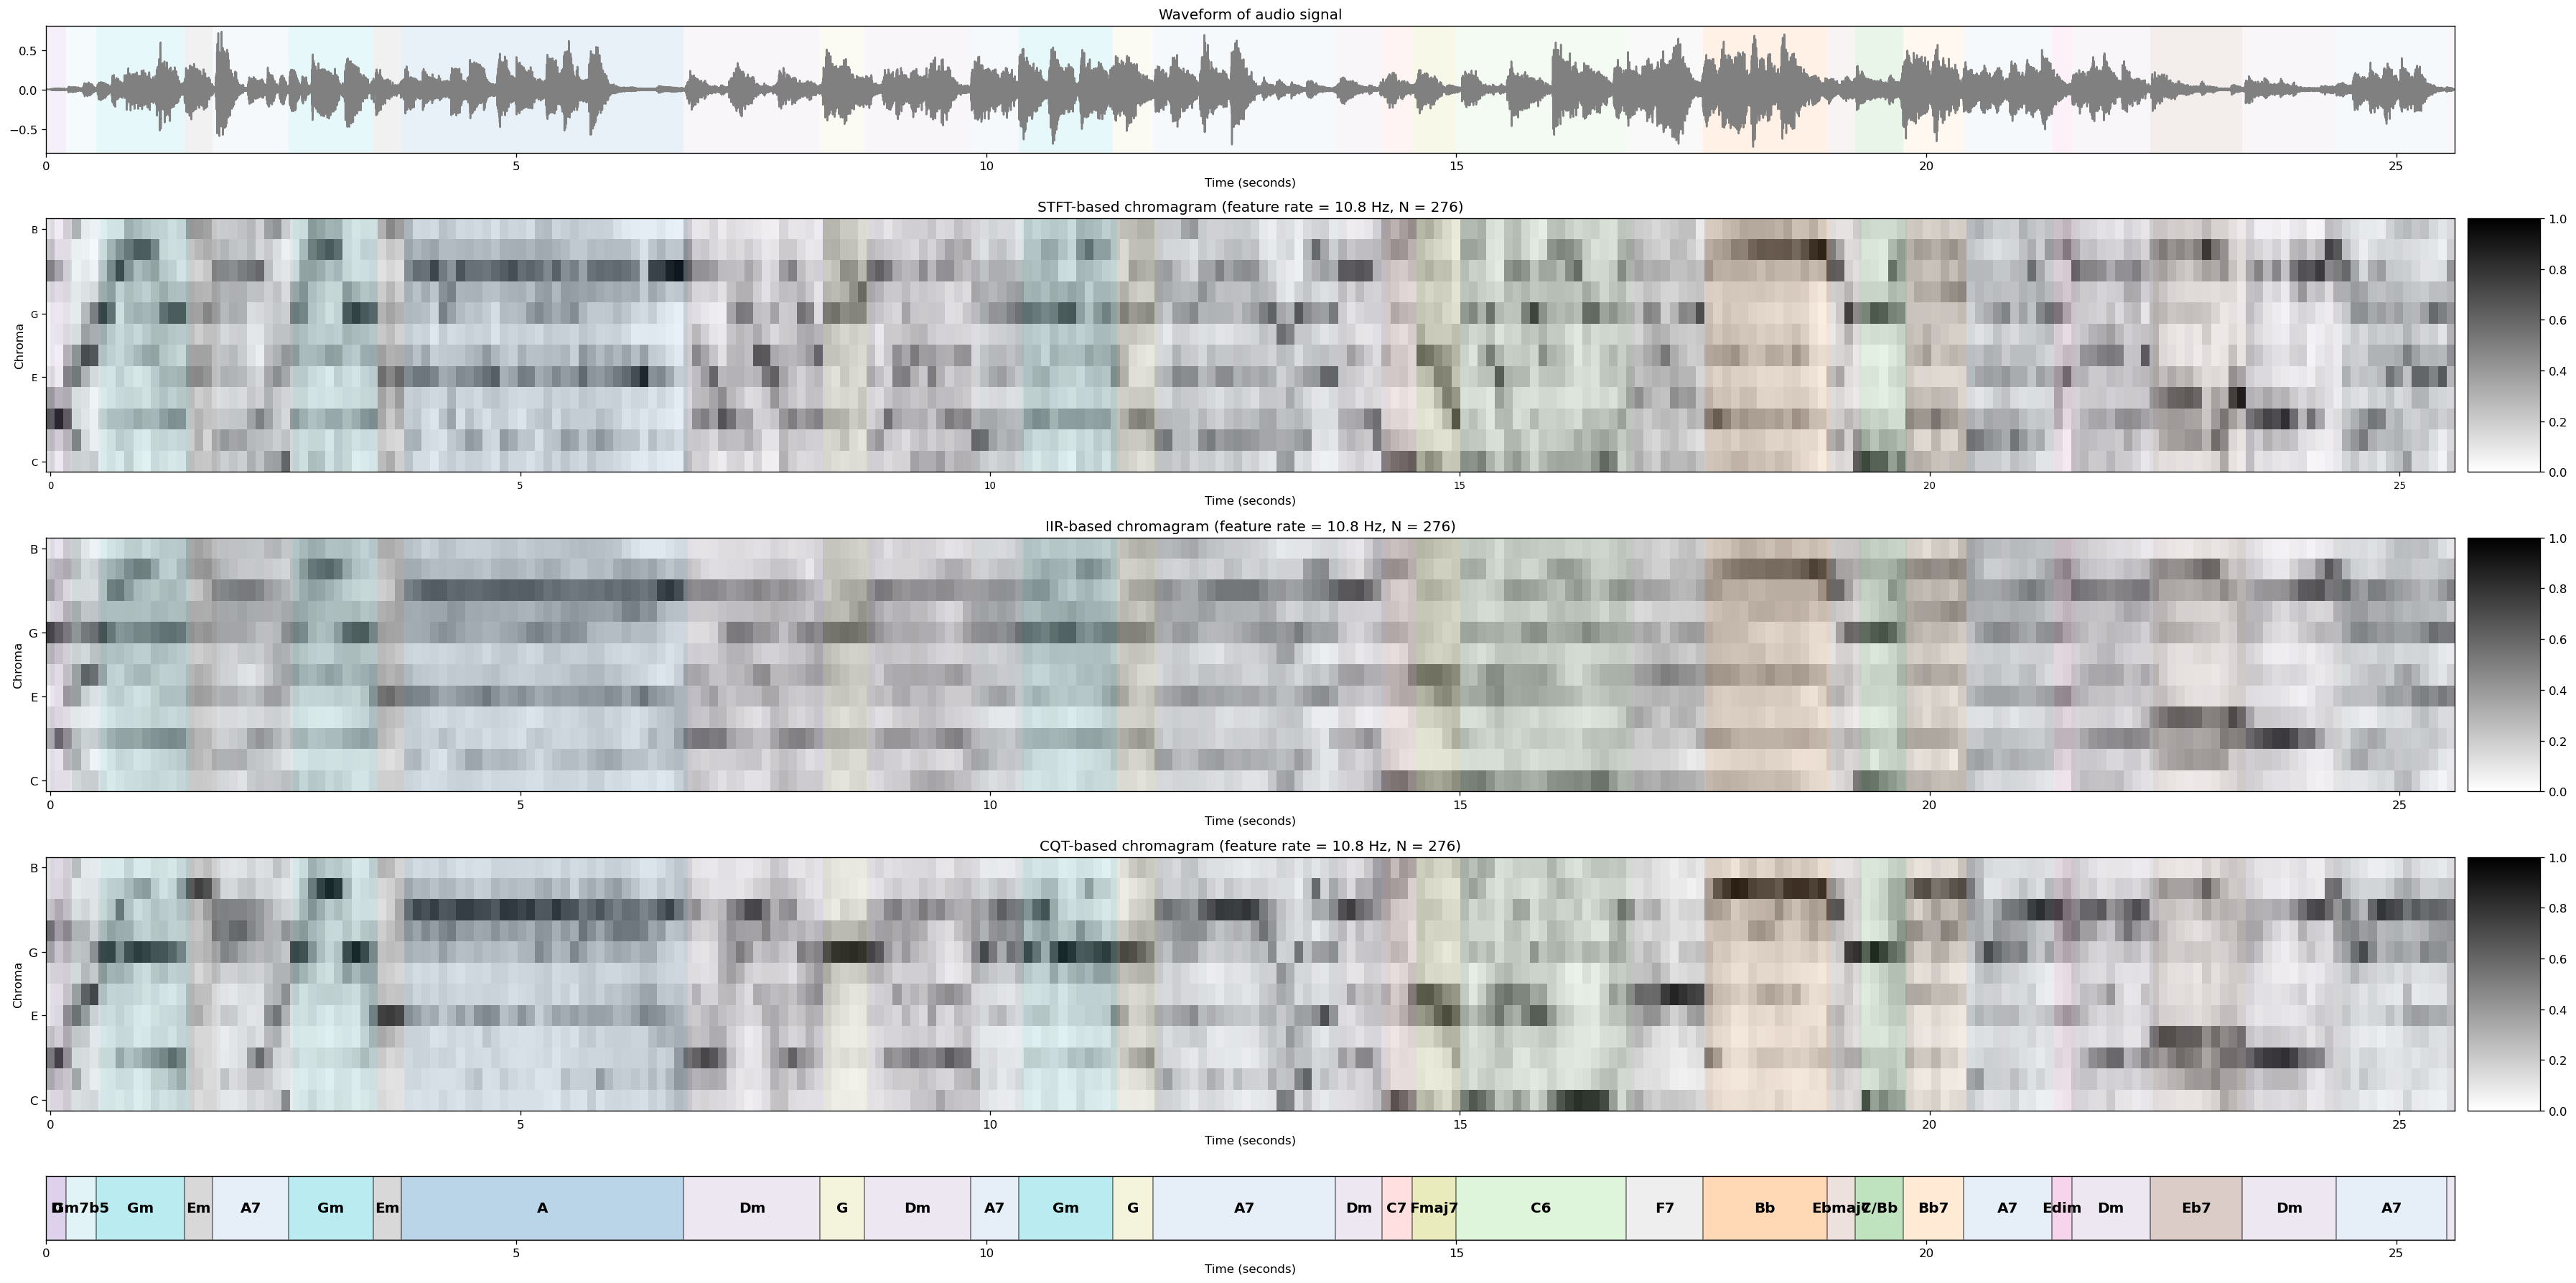

In [33]:
# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 2, 2, 0.5]}, figsize=(30, 15), dpi=120)
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')
libfmp.b.plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)
ax[0,1].axis('off')

ax[1, 0].tick_params(axis='y', labelsize=8)  # reduce y-axis label font size
ax[1, 0].tick_params(axis='x', labelsize=8)  # reduce x-axis label font size

title = 'STFT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_STFT.shape[1])
plot_chromagram_annotation([ax[1, 0], ax[1, 1]], X_STFT, Fs_X, ann, color_ann, x_dur, title=title)

title = 'IIR-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_IIR.shape[1])
plot_chromagram_annotation([ax[2, 0], ax[2, 1]], X_IIR, Fs_X, ann, color_ann, x_dur, title=title)

title = 'CQT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT.shape[1])
plot_chromagram_annotation([ax[3, 0], ax[3, 1]], X_CQT, Fs_X, ann, color_ann, x_dur, title=title)

libfmp.b.plot_segments(ann, ax=ax[4, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[4,1].axis('off')
plt.tight_layout()

In [8]:
def get_chord_labels(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

In [9]:
def get_chord_labels_extended(nonchord=False):
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 
                     'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Triads
    chord_labels_maj = chroma_labels
    chord_labels_min = [note + 'm' for note in chroma_labels]

    # Seventh chords
    chord_labels_dom7 = [note + '7'    for note in chroma_labels]
    chord_labels_maj7 = [note + 'maj7' for note in chroma_labels]
    chord_labels_min7 = [note + 'm7'   for note in chroma_labels]

    chord_labels = (chord_labels_maj 
                    + chord_labels_min
                    + chord_labels_dom7
                    + chord_labels_maj7
                    + chord_labels_min7)

    if nonchord:
        chord_labels += ['N']

    return chord_labels

In [11]:
def generate_chord_templates(nonchord=False):
    """Generate chord templates for:
    - 12 major triads
    - 12 minor triads
    - 12 dominant seventh chords
    - 12 major seventh chords
    - 12 minor seventh chords
    - (Optional) one nonchord template (if nonchord=True)

    Returns:
        chord_templates (np.ndarray):
            Matrix of shape (12, num_chords), where each column is a binary chord template
    """
    # --- 1) Define base (C-root) triad templates ---
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])  # (C, E, G)
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])  # (C, Eb, G)

    # --- 2) Define base (C-root) seventh-chord templates ---
    # intervals for C7 = {0,4,7,10} (C, E, G, Bb)
    template_c7 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])

    # intervals for Cmaj7 = {0,4,7,11} (C, E, G, B)
    template_cmaj7 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

    # intervals for Cm7 = {0,3,7,10} (C, Eb, G, Bb)
    template_cm7 = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])

    # --- 3) Prepare storage for all roots (12 columns per chord type) ---
    chord_templates_maj   = np.zeros((12, 12))
    chord_templates_min   = np.zeros((12, 12))
    chord_templates_dom7  = np.zeros((12, 12))
    chord_templates_maj7  = np.zeros((12, 12))
    chord_templates_min7  = np.zeros((12, 12))

    # --- 4) Fill each chord-type matrix by cyclically shifting the base templates ---
    for shift in range(12):
        chord_templates_maj[:, shift]   = np.roll(template_cmaj, shift)
        chord_templates_min[:, shift]   = np.roll(template_cmin, shift)
        chord_templates_dom7[:, shift]  = np.roll(template_c7,   shift)
        chord_templates_maj7[:, shift]  = np.roll(template_cmaj7, shift)
        chord_templates_min7[:, shift]  = np.roll(template_cm7,   shift)

    # --- 5) Stack the chord types horizontally ---
    #    major triads (12) + minor triads (12) +
    #    dominant 7 (12) + major 7 (12) + minor 7 (12) = 60 columns
    chord_templates = np.hstack([
        chord_templates_maj,
        chord_templates_min,
        chord_templates_dom7,
        chord_templates_maj7,
        chord_templates_min7
    ])

    # --- 6) Optionally add a "nonchord" column if requested ---
    if nonchord:
        # e.g. a zero vector or all-ones vector, depending on your preference.
        # Here we add a zero vector:
        nonchord_col = np.zeros((12, 1))  
        chord_templates = np.hstack([chord_templates, nonchord_col])

    return chord_templates


In [12]:
def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

In [13]:
# Chord recognition
X = X_STFT
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
#chord_labels = get_chord_labels(nonchord=False)
chord_labels = get_chord_labels_extended(nonchord=False)

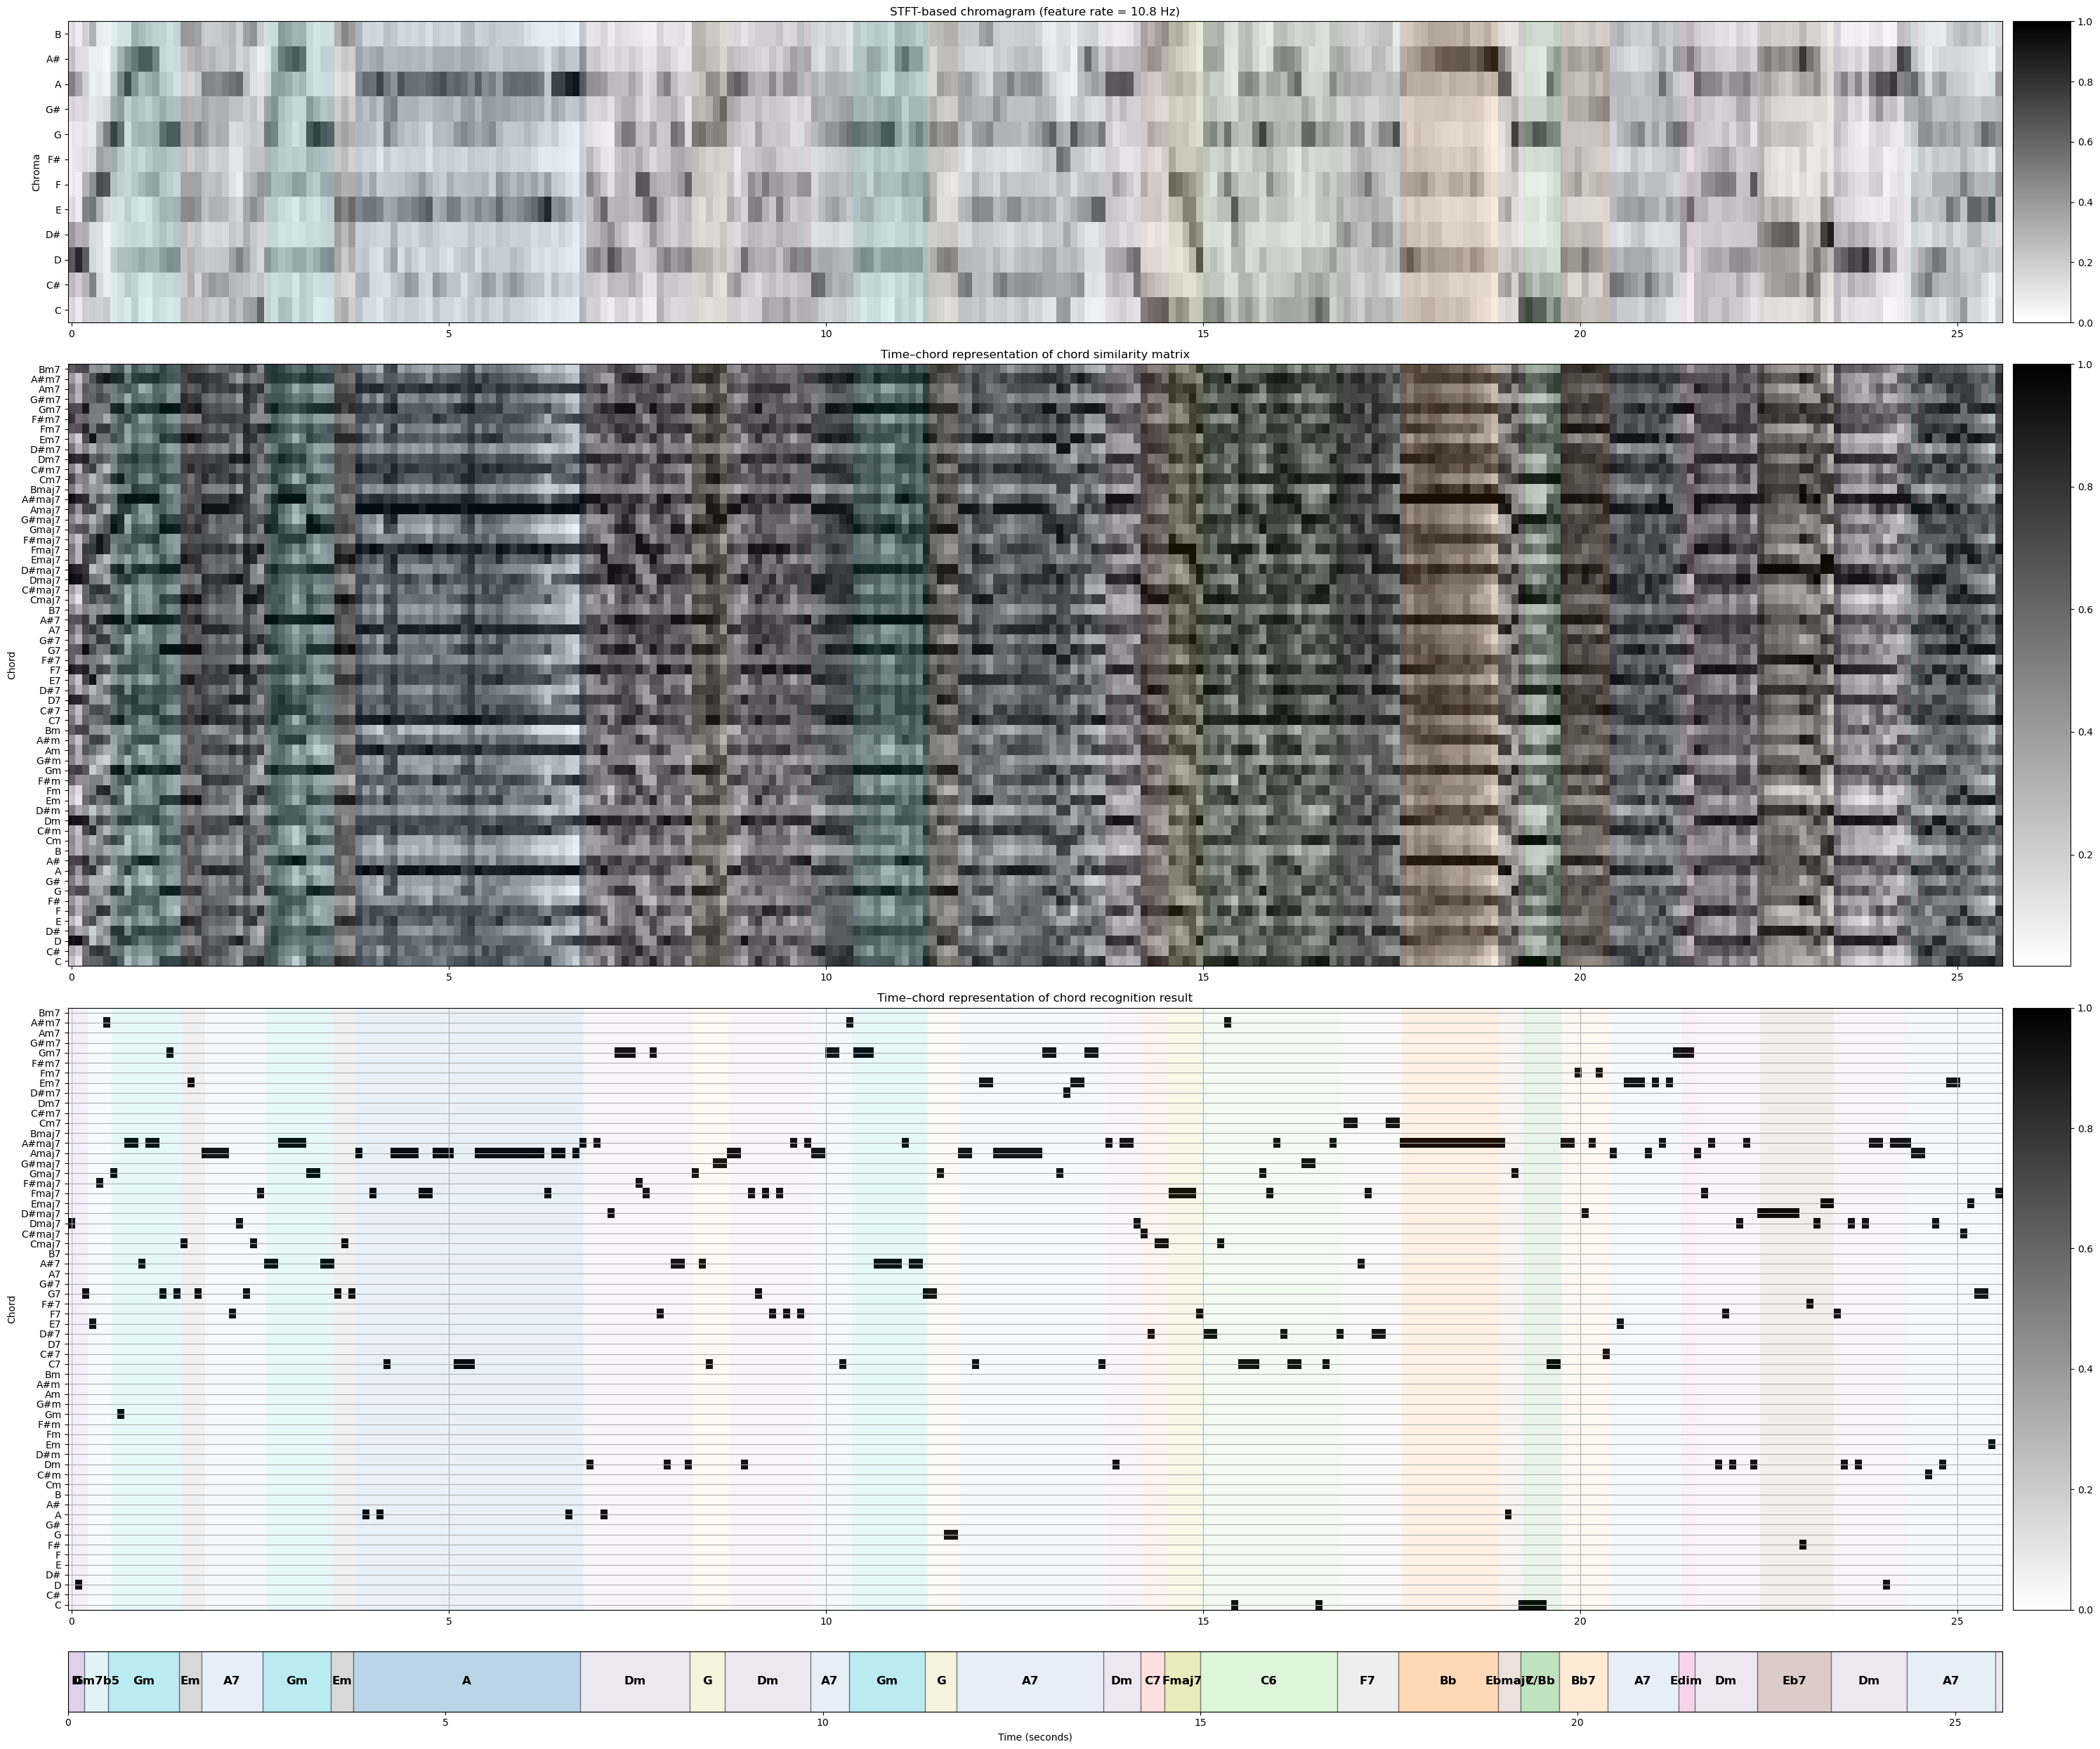

In [35]:
# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3, 0.3]}, figsize=(30, 25))
libfmp.b.plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
libfmp.b.plot_segments_overlay(ann, ax=ax[2, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(ann, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

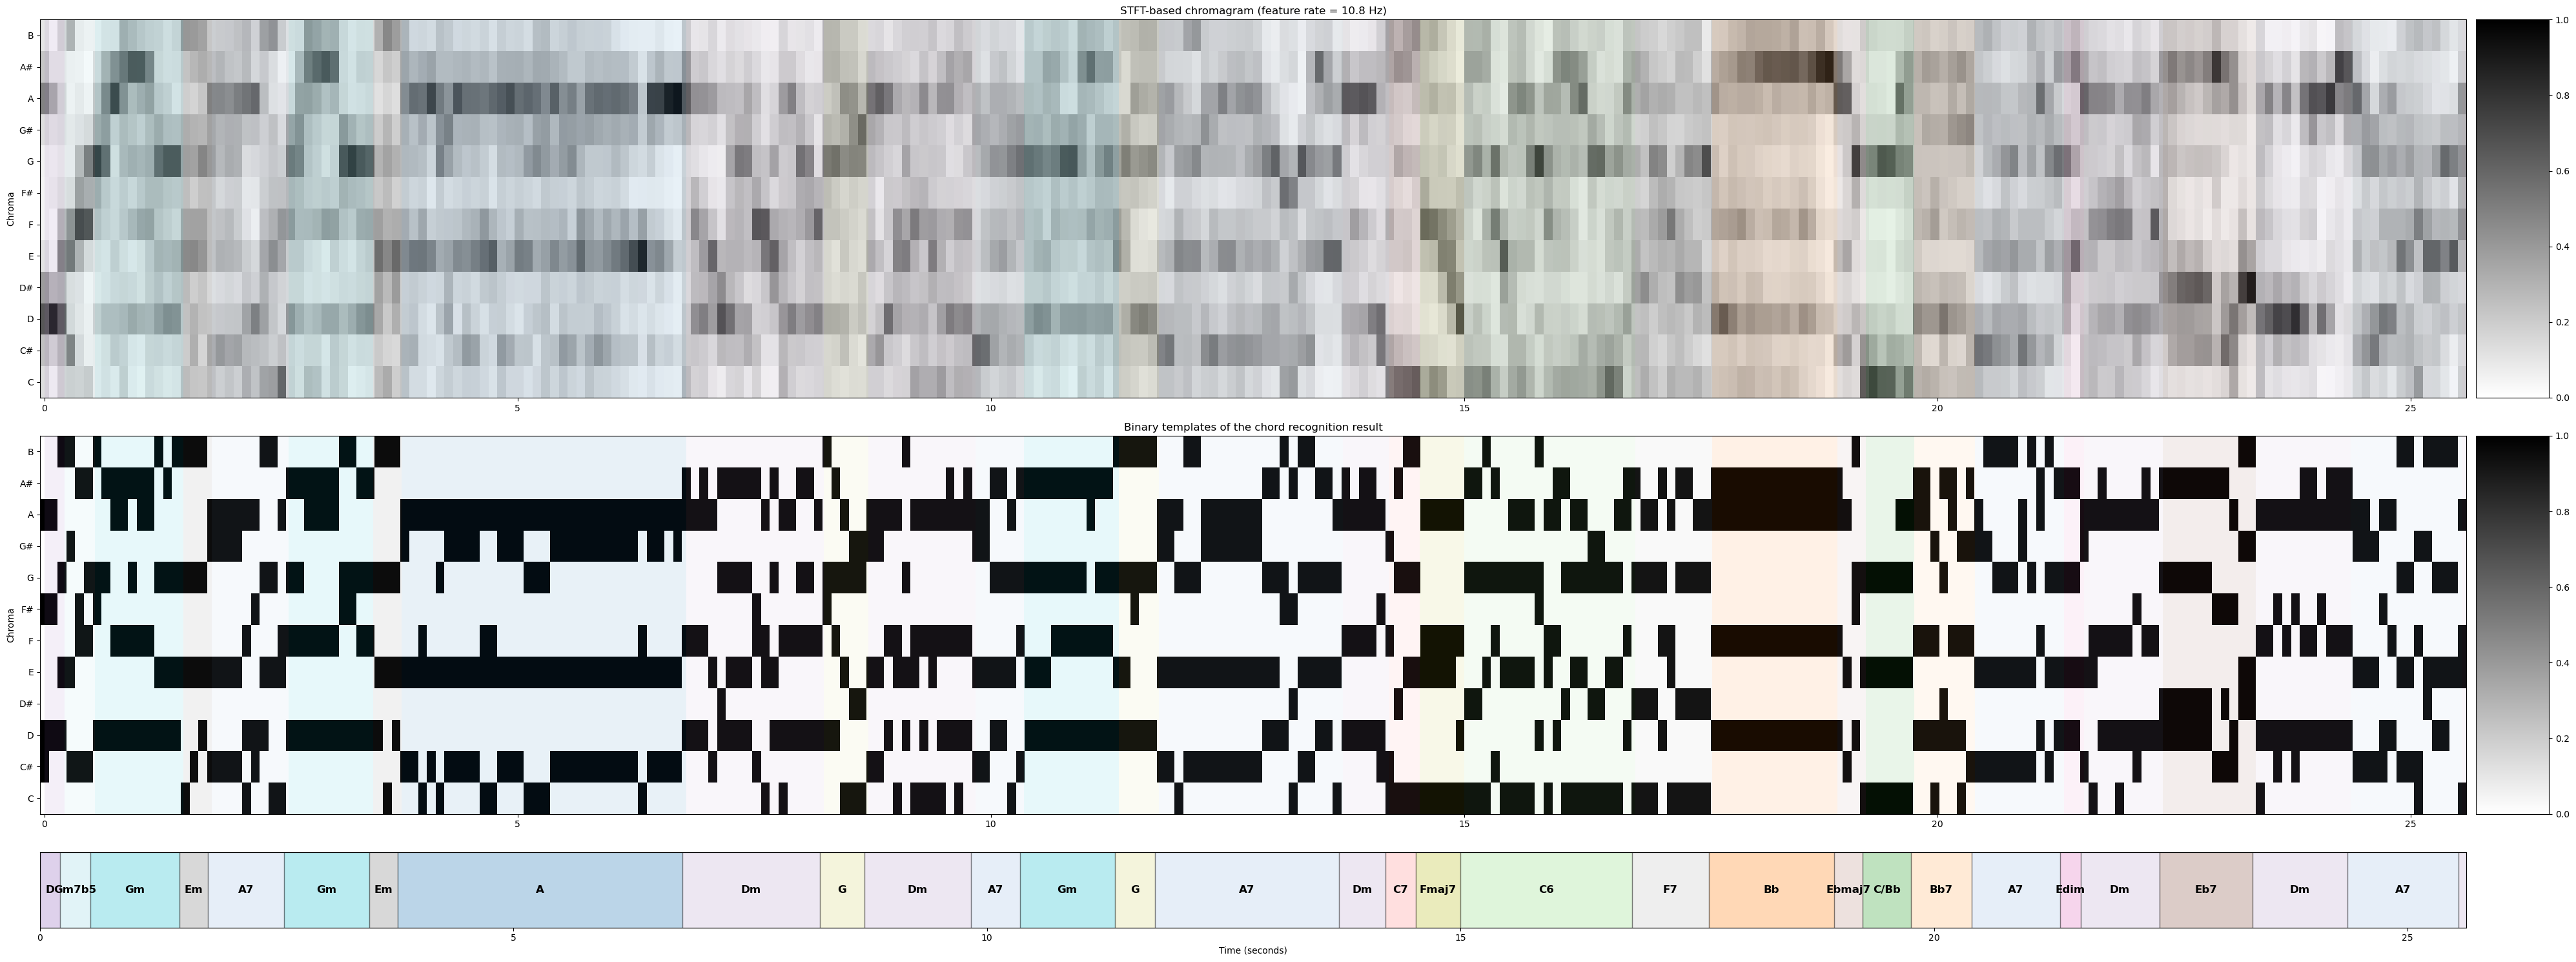

In [37]:
chord_templates = generate_chord_templates() 
X_chord = np.matmul(chord_templates, chord_max)

# Plot
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 1, 0.2]}, figsize=(40, 15))

libfmp.b.plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_segments_overlay(ann, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_chromagram(X_chord, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='Binary templates of the chord recognition result')
libfmp.b.plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(ann, ax=ax[2, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[2,1].axis('off')
plt.tight_layout()